In [4]:

import findspark
from pyspark.sql import SparkSession

findspark.init()
spark = SparkSession\
        .builder\
        .master("local[2]")\
        .appName("Spark MLlib")\
        .getOrCreate()
spark.sparkContext

<SparkContext master=local[2] appName=Spark MLlib>

In [9]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

In [8]:
df = spark.read.csv("Otodom_Flat_Listings.csv", header=True, inferSchema=True)

+--------------------+----------+------------------+
|            features|     Price|        prediction|
+--------------------+----------+------------------+
|(17,[0,1,4],[51.5...|  599000.0| 922241.8061910289|
|(17,[0,1,2],[88.0...| 1490000.0|2547292.7164368634|
|(17,[0,1,10],[78....| 1102500.0|2062479.7841638257|
|(17,[0,1,4],[49.4...|  209000.0|502734.39008844097|
|(17,[0,1,5],[60.2...|  450000.0| 2330715.081287523|
|(17,[0,1,5],[64.6...|  477000.0|2339867.0978531945|
|(17,[0,1,5],[45.9...|  183000.0|  1886075.63404806|
|(17,[0,1,3],[58.2...| 1050000.0|1187845.1569322073|
|(17,[0,1,12],[77....|  650000.0| 615231.3566849352|
|(17,[0,1,7],[38.0...|  458280.0|1123216.3158558435|
|(17,[0,1,7],[65.0...|6.942915E7|2009451.3898164765|
|(17,[0,1,7],[36.1...|  429656.0|1119473.2483901926|
|(17,[0,1,7],[41.8...|  483891.0|1131175.4749344056|
|(17,[0,1,7],[48.5...|  523971.0|1560246.2274904232|
|(17,[0,1,6],[35.4...|  540000.0| 675827.9425787987|
|(17,[0,1,4],[30.6...|  538824.0| 48655.007069

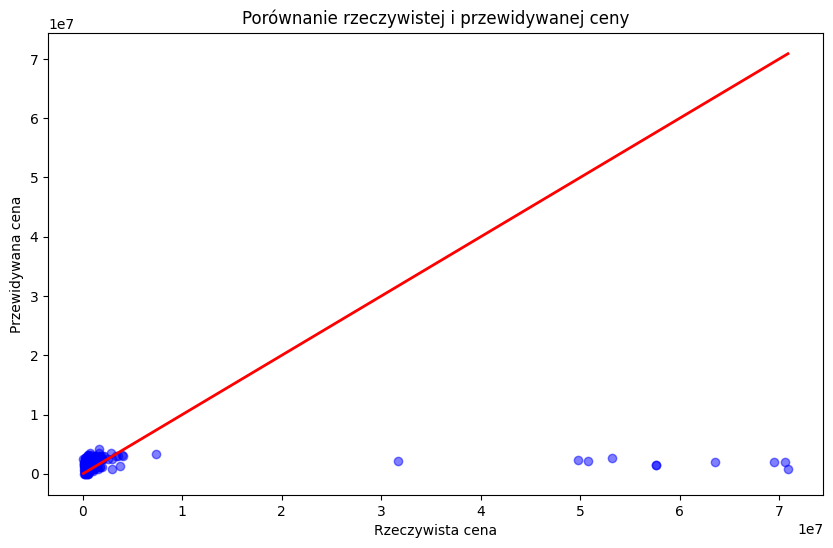

In [10]:
df_cleaned = df.dropna(subset=['Price', 'Surface', 'Number_of_Rooms', 'Voivodeship'])

df_cleaned = df_cleaned.withColumn("Surface", col("Surface").cast("float"))
df_cleaned = df_cleaned.withColumn("Number_of_Rooms", col("Number_of_Rooms").cast("int"))

df_cleaned = df_cleaned.fillna({'Surface': 0.0, 'Number_of_Rooms': 0})

indexer = StringIndexer(inputCol="Voivodeship", outputCol="Voivodeship_indexed", handleInvalid="skip")
encoder = OneHotEncoder(inputCol="Voivodeship_indexed", outputCol="Voivodeship_onehot")

assembler = VectorAssembler(inputCols=["Surface", "Number_of_Rooms", "Voivodeship_onehot"], outputCol="features", handleInvalid="skip")

lr = LinearRegression(featuresCol="features", labelCol="Price")

pipeline = Pipeline(stages=[indexer, encoder, assembler, lr])

train_data, test_data = df_cleaned.randomSplit([0.8, 0.2])

model = pipeline.fit(train_data)

predictions = model.transform(test_data)

predictions.select("features", "Price", "prediction").show()

evaluator_rmse = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")

predicted_values = predictions.select("Price", "prediction").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predicted_values['Price'], predicted_values['prediction'], color='blue', alpha=0.5)
plt.plot([min(predicted_values['Price']), max(predicted_values['Price'])],
         [min(predicted_values['Price']), max(predicted_values['Price'])],
         color='red', lw=2)
plt.xlabel('Rzeczywista cena')
plt.ylabel('Przewidywana cena')
plt.title('Porównanie rzeczywistej i przewidywanej ceny')
plt.show()